In [52]:
import numpy as np
from numpy.random import multivariate_normal
import pandas as pd
from advectionGP.models.mesh_adr2d_model import AdjointAdvectionDiffusionReaction2DModel as PDEModel 
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple

import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
k_0 = 0.01
R=0
noiseSD = 0.05
N_feat=200
boundary = ([0,0,0],[10,10,10])
k = EQ(5, 2.0) #not used.
res = [400,150,150]
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
u=[]
u.append(np.ones(res)*wind)
u.append(np.ones(res)*0.0)
windmodel=WindSimple(0.4,0.4)

tlocL = np.linspace(1,8,5) # lower time
xloc=np.linspace(2,8,5) # x locations
yloc=np.linspace(2,8,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4))
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1)

m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R)
#z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
#sourceGT=(m.computeSourceFromPhi(z))
sourceGT = np.zeros([50,30,30])

from scipy.stats import norm
def getrealsource(p):
    blobcentre = np.array([3,3,3]) 
    blobsize = np.array([1,1,1])
    blobheight = 20
    return blobheight*norm(0,1).pdf(np.linalg.norm((np.transpose(np.array(m.coords[:,...]),[1,2,3,0])-blobcentre)/blobsize,axis=3))

sourceGT = getrealsource(m.coords)
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
Y = m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

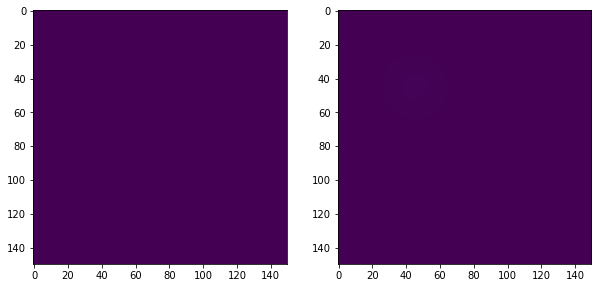

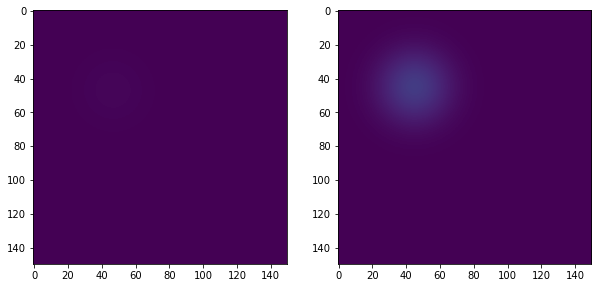

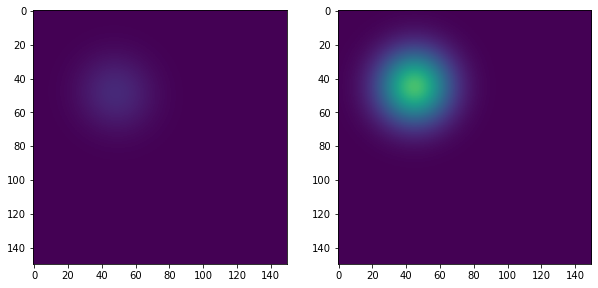

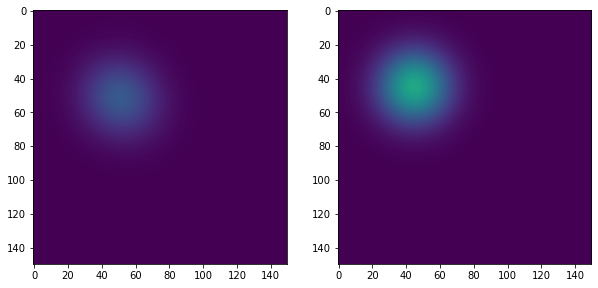

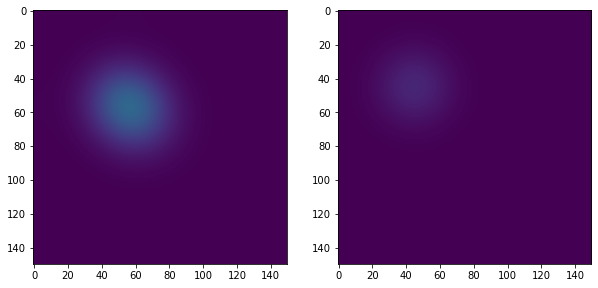

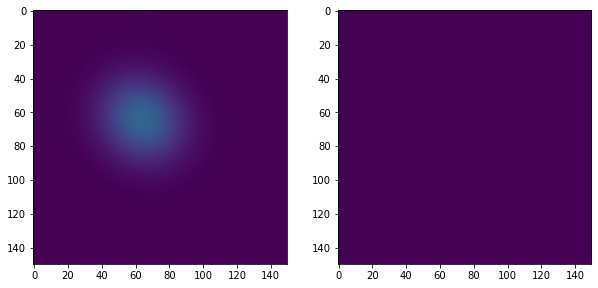

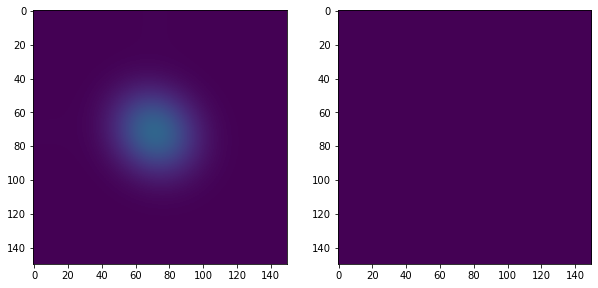

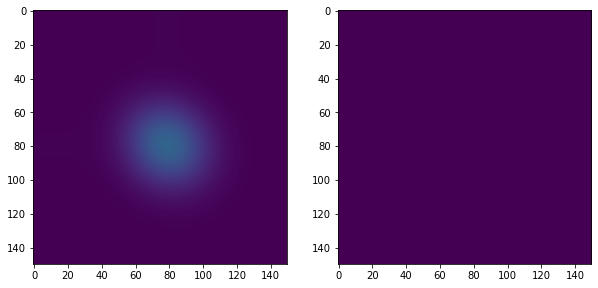

In [66]:
for tstep in range(0,400,50):
    plt.figure(figsize=[10,5])
    plt.subplot(1,2,1)
    plt.imshow(concTrain[tstep,:,:])
    #plt.colorbar()
    plt.clim([0,50])
    plt.subplot(1,2,2)
    plt.imshow(sourceGT[tstep,:,:])
    #plt.colorbar()
    plt.clim([0,10])

In [82]:
np.random.seed(42)

N_feat = 500 #Number of features used to infer the source
#k = GaussianBases(0.5,3.0) #
k = EQ(1, 2.0)
res = [70,30,30]
noiseSD = 0.05
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(0.4,0.4)
k_0 = 0.01

from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as MFModel
mInfer = MFModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0)
mInfer.computeModelRegressors(Nparticles=20)
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

Nsamps = 4
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)
print("Actual number of features: %d" % k.N_feat)

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
Actual number of features: 500


In [83]:
scaleby = [3,1,1]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]] #20x10x10
concmean,concvar,conc = mInfer.computeConcentration(Zs=Zs,Nsamps=10,Nparticles=10,interpolateSource=True,coords=coords)

Initialising particles...
Particle shape:
(10, 24, 30, 30, 3)
Diffusing particles...


In [84]:
#Non-negative...
r = 12
nonNegFrom = mInfer.boundary[0]
nonNegTo = mInfer.boundary[1]
Xnonneg = np.array(np.meshgrid(np.linspace(nonNegFrom[0],nonNegTo[0],r+2)[1:-1],np.linspace(nonNegFrom[1],nonNegTo[1],r+2)[1:-1],np.linspace(nonNegFrom[2],nonNegTo[2],r+2)[1:-1]))
Xnonneg = Xnonneg.reshape(3,r**3).T

from advectionGP.constraints import NonNegConstraint
nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=40,burnin=100,jitter=0.02,verbose=False)
Zs_nonneg = nnc.sample(Nsamps)

Computing SS...
Inverting SS...
Computing meanZ
Done


In [85]:
sources_nonneg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs_nonneg])
sourcemean_nonneg = np.mean(sources_nonneg,0)
sourcevar_nonneg = np.var(sources_nonneg,0)

cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...


In [86]:
concmean_nonneg,concvar_nonneg,conc_nonneg = mInfer.computeConcentration(Zs=Zs_nonneg,Nsamps=10,Nparticles=10,interpolateSource=True,coords=coords)

Initialising particles...
Particle shape:
(10, 24, 30, 30, 3)
Diffusing particles...


In [87]:
#nnc.check_convergence(5,10)
#with 0 jitter & r=10 & thinning = 30 -> 14.7
#with 0.1 jitter &r=8 & thinning = 50 -> 

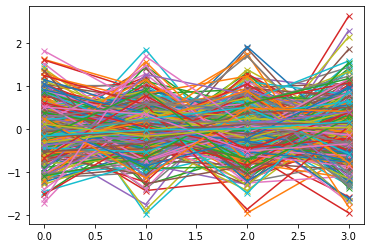

In [88]:
plt.plot(Zs_nonneg-np.mean(Zs_nonneg,0),'x-');

In [89]:
np.unique(mInfer.getGridCoord(Xnonneg)[:,1])

array([ 2,  4,  6,  9, 11, 13, 16, 18, 20, 23, 25, 27])

In [92]:
5/70

0.07142857142857142

In [91]:
np.unique(mInfer.getGridCoord(Xnonneg)[:,0])

array([ 5, 10, 16, 21, 26, 32, 37, 43, 48, 53, 59, 64])

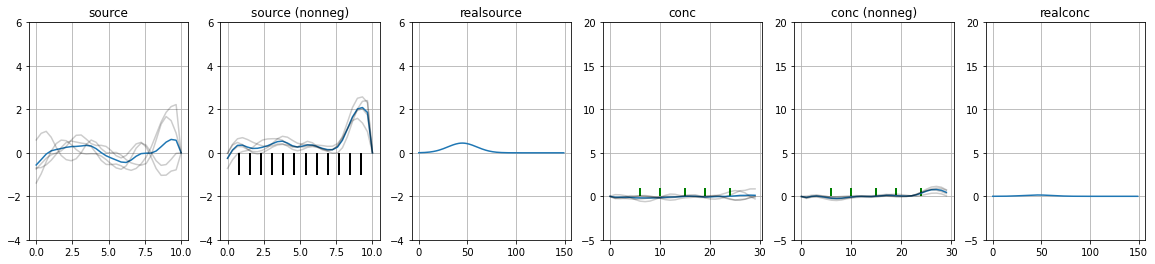

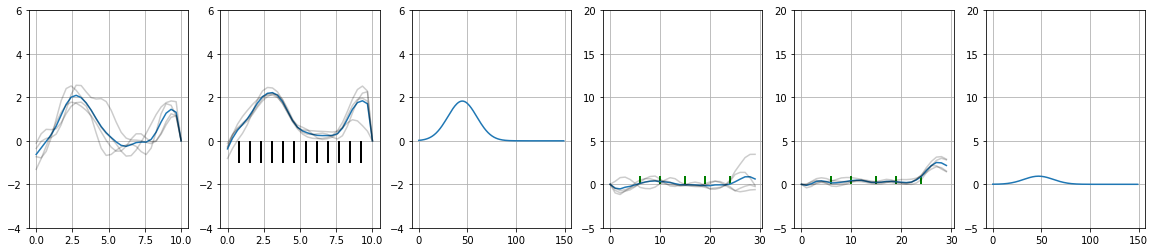

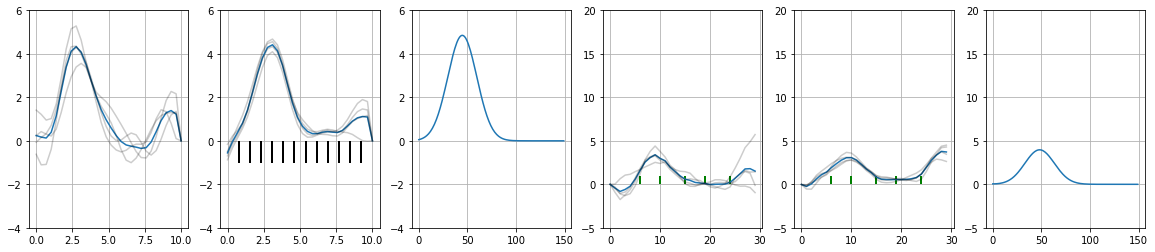

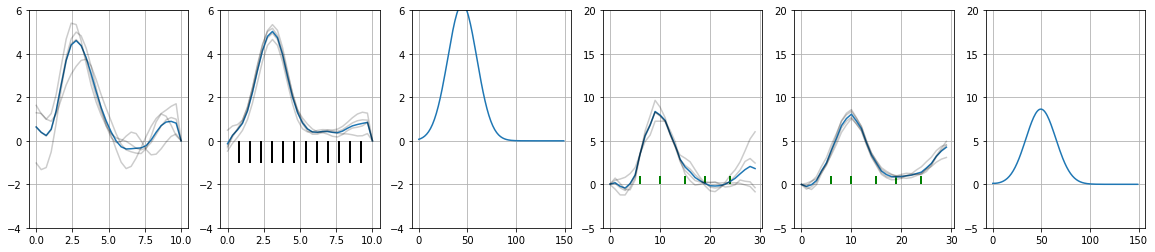

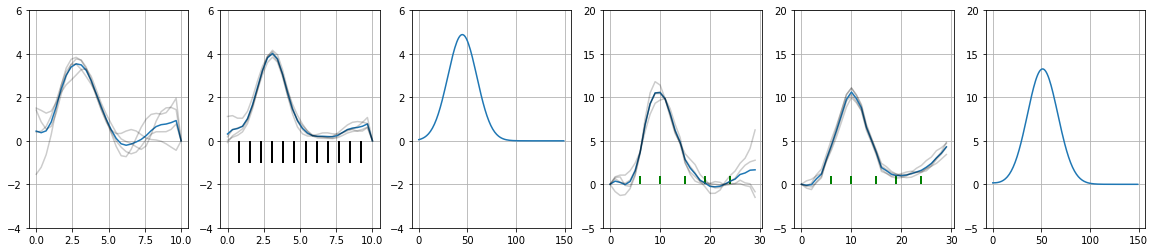

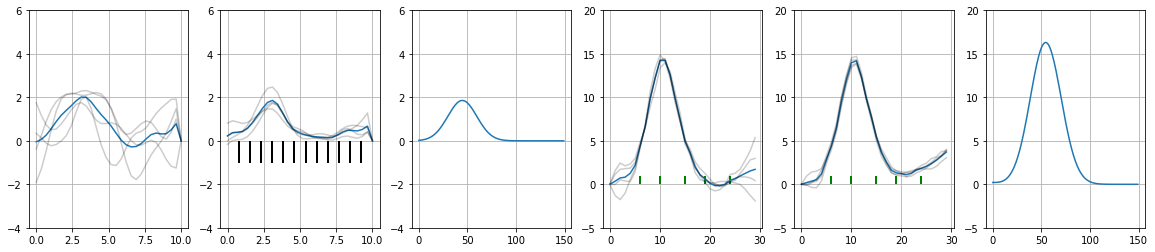

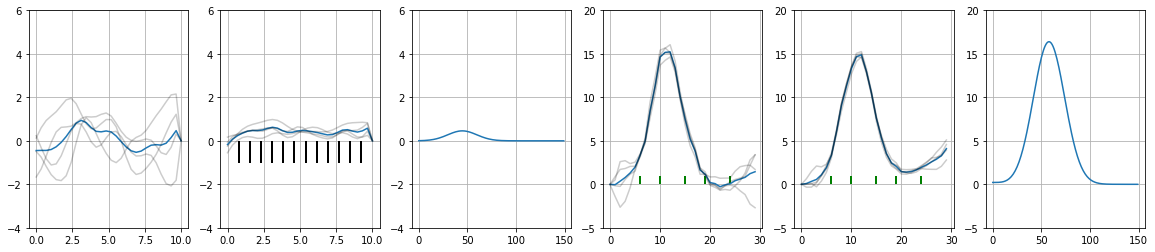

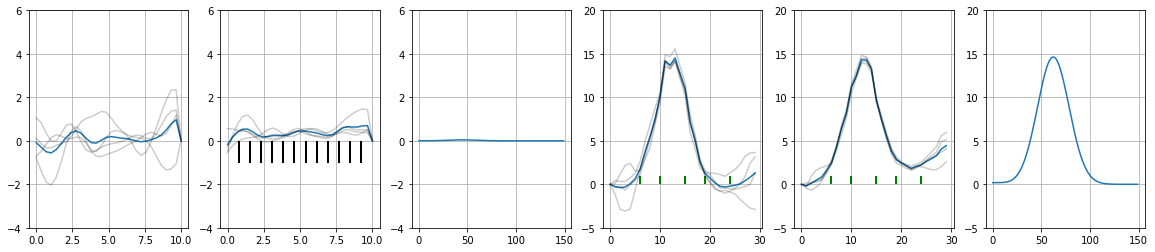

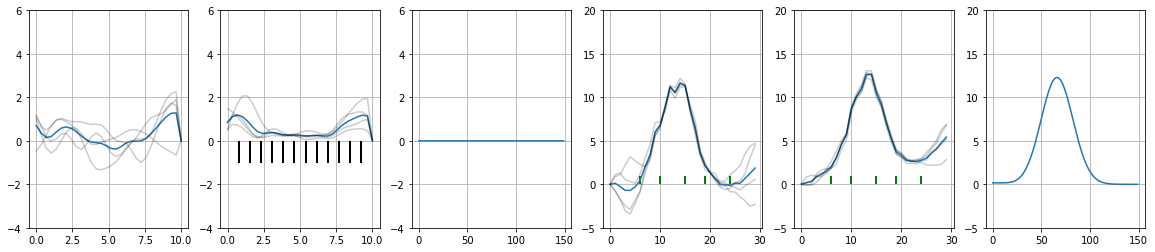

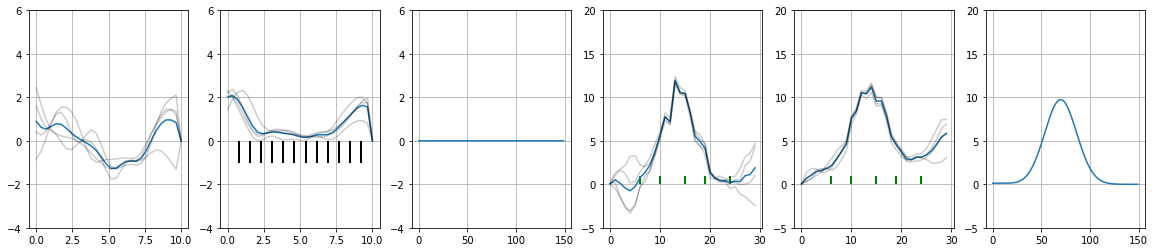

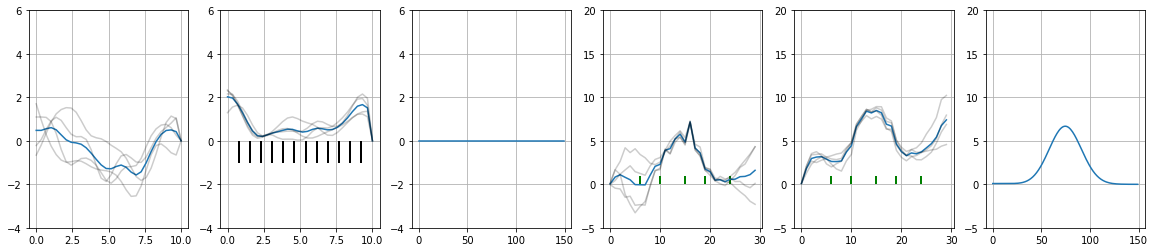

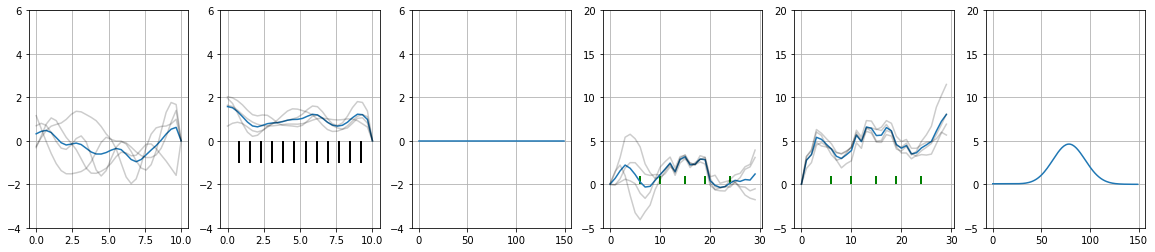

In [90]:
slice_coord=11
gridX = mInfer.getGridCoord(X[:,1:])
plot1d = True
firstrow = True
source_lims = [-4,6]
conc_lims = [-5,20]

for tsamp in np.unique(mInfer.getGridCoord(Xnonneg)[:,0]):
    plt.figure(figsize=[20,4])
    plt.subplot(1,6,1)
    if firstrow: plt.title('source')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources[:,tsamp,slice_coord,:].T,'k-',alpha=0.2)
        plt.ylim(source_lims)
        plt.grid()
    else:
        plt.imshow(sourcemean[tsamp,:,:])
        plt.colorbar()
        plt.clim(source_lims)
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')

    plt.subplot(1,6,2)
    if firstrow: plt.title('source (nonneg)')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean_nonneg[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources_nonneg[:,tsamp,slice_coord,:].T,'k-',alpha=0.2)
        plt.vlines(Xnonneg[:,2],0,-1)
        plt.ylim([-4,6])
        plt.grid()
    else:
        plt.imshow(sourcemean_nonneg[tsamp,:,:])
        plt.colorbar()
        plt.clim(source_lims)
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    
    plt.subplot(1,6,3)
    if firstrow: plt.title('realsource')
    if plot1d:    
        plt.plot(sourceGT[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),int(slice_coord*(m.resolution[1]/mInfer.resolution[1])),:])
        plt.grid()
        plt.ylim(source_lims)
    else:
        plt.imshow(sourceGT[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),:,:])   
        plt.clim(source_lims)
        plt.colorbar()    
#    plt.subplot(1,4,2)
#    if tsamp==0: plt.title('std')
#    if plot1d:    
#        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],np.sqrt(sourcevar[tsamp,slice_coord,:]))
#        plt.grid()
#        plt.ylim([0,2])
#    else:
#        plt.imshow(np.sqrt(sourcevar[tsamp,:,:]))
#        plt.clim([0,2])
#        plt.colorbar()
#        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,6,4)
    if firstrow: plt.title('conc')
    if plot1d:    
        plt.plot(concmean[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.plot(conc[:,tsamp//scaleby[0],slice_coord//scaleby[1],:].T,'k-',alpha=0.2)
        plt.grid()
        plt.ylim(conc_lims)
        plt.vlines(gridX[:,2],0,1,color='green')
    else:
        plt.imshow(concmean[tsamp//scaleby[0],:,:])
        plt.clim(conc_lims)
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')

    plt.subplot(1,6,5)
    if firstrow: plt.title('conc (nonneg)')
    if plot1d:    
        plt.plot(concmean_nonneg[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.plot(conc_nonneg[:,tsamp//scaleby[0],slice_coord//scaleby[1],:].T,'k-',alpha=0.2)
        plt.grid()
        plt.ylim(conc_lims)
        plt.vlines(gridX[:,2],0,1,color='green')
    else:
        plt.imshow(concmean_nonneg[tsamp//scaleby[0],:,:])        
        plt.clim(conc_lims)
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')
    
    plt.subplot(1,6,6)
    if firstrow: plt.title('realconc')
    if plot1d:    
        plt.plot(concTrain[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),int(slice_coord*(m.resolution[1]/mInfer.resolution[1])),:])
        plt.grid()
        plt.ylim(conc_lims)   
    else:
        plt.imshow(concTrain[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),:,:])   
        plt.clim(conc_lims)
        plt.colorbar()
    firstrow = False